

#**LMMS Transigrafo**

##**Introduction**

In this notebook we show our implementation of Transigrafo as a extension of the code for Language Modelling Makes Sense (ACL 2019), which uses contextual embeddings in Word Sense Disambiguation (WSD) tasks.

![alt text](https://github.com/hybridnlp/LMMS/raw/master/misc/lmms_org.png)

The figure up above shows the workflow of LMMS. We are going to focus only in the two first phases: training (train.py) and extension (extend.py), to obtain contextual embeddings, extend them semantically with wordnet and finally evaluate them. Sense embeddings based on WordNet's glosses (emb_glosses.py) and lemmas (emb_lemmas.py) are out of the scope of this tutorial.

Our main modifications from the original repository include:

*   Support for transformers backend. This makes it possible to experiment with other transformer architectures besides BERT, e.g. XLNet, XLM, RoBERTa optimised training since we no longer have to pad sequences to 512 wordpiece tokens
*   Introduced *SentenceEncoder* which is an experimental generalisation of bert-as-service like encoding services using the transformers backend allows to extract various types of embeddings from a single execution of a batch of sequences.
*   Rolling cosine similarity metrics during training phase

##**Setup**

Execute the following cell to clone the repo and change the directory to LMMS:

In [0]:
!git clone https://github.com/hybridnlp/LMMS
%cd /content/LMMS

Cloning into 'LMMS'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 202 (delta 32), reused 25 (delta 13), pack-reused 144
Receiving objects: 100% (202/202), 171.80 KiB | 945.00 KiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/LMMS


Then, import and download the nltk interface for Wordnet, and install the transformers library, needed to execute the LMMS scripts

In [0]:
import nltk
nltk.download("wordnet")
!pip install transformers==2.1.1

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 317kB 7.1MB/s 
     |████████████████████████████████| 645kB 44.1MB/s 
     |████████████████████████████████| 1.0MB 29.0MB/s 
     |████████████████████████████████| 860kB 28.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=1f44485c526fc27f6c749ca2e37f151a5c74c7b87e0fe6615518ae49dd428807
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


For this notebook, we are going to use a semantically annotated English corpus: SemCor. The semantic analysis was done manually with WordNet 1.6 senses (SemCor version 1.6) and later automatically mapped to WordNet 3.0 (SemCor version 3.0). The SemCorpus corpus consists of 352 texts from Brown corpus. 

Execute the following cell to download, unzip the SemCor corpus.

In [0]:
!mkdir external/wsd_eval
%cd external/wsd_eval
!wget http://lcl.uniroma1.it/wsdeval/data/WSD_Evaluation_Framework.zip
!unzip WSD_Evaluation_Framework
%cd /content/LMMS/

/content/LMMS/external/wsd_eval
--2019-11-08 12:21:48--  http://lcl.uniroma1.it/wsdeval/data/WSD_Evaluation_Framework.zip
Resolving lcl.uniroma1.it (lcl.uniroma1.it)... 151.100.179.52
Connecting to lcl.uniroma1.it (lcl.uniroma1.it)|151.100.179.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165655083 (158M) [application/zip]
Saving to: ‘WSD_Evaluation_Framework.zip’

WSD_Evaluation_Fram 100%[===================>] 157.98M  11.2MB/s    in 14s     

2019-11-08 12:22:03 (11.1 MB/s) - ‘WSD_Evaluation_Framework.zip’ saved [165655083/165655083]

Archive:  WSD_Evaluation_Framework.zip
   creating: WSD_Evaluation_Framework/
   creating: WSD_Evaluation_Framework/Data_Validation/
  inflating: WSD_Evaluation_Framework/Data_Validation/README  
  inflating: WSD_Evaluation_Framework/Data_Validation/ValidateGold.java  
  inflating: WSD_Evaluation_Framework/Data_Validation/ValidateXML.java  
  inflating: WSD_Evaluation_Framework/Data_Validation/candidatesWN30.txt  
   creati

##**Training**

We use transformers backend to train the model with the SemCor corpus, since the bert_as_a_service option is not possible in Google Colab. This training will create, after a while, the following files in the output folder:

* **semcor..4-8.vecs.txt** for each sense the computed embedding

* **semcor..4-8.counts.txt** for each sense, how often did it occur in the training corpus

* **semcor..4-8.rolling_cosims.txt** for each sense, a sequence of cosims between the current average emb and the next occurrence in the training corpus

* **lmms_config.json** a record of the args used during training


***DISCLAIMER: For the purpose of this tutorial, we reduce the length of sentences from the corpus to 4-8 tokens, so we can execute all the cells of the notebook within a reasonable time. If you want to execute it with the whole corpus, just delete the min_seq_len and max_seq_len arguments***

In [0]:
%%time
!python train.py -dataset semcor -backend transformers -out_path data/vectors/semcor.txt -min_seq_len 4 -max_seq_len 8

08-Nov-19 12:22:19 - INFO - Creating TransformerSentenceEncoder
08-Nov-19 12:22:19 - DEBUG - Starting new HTTPS connection (1): s3.amazonaws.com:443
08-Nov-19 12:22:20 - DEBUG - https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-large-cased-vocab.txt HTTP/1.1" 200 0
08-Nov-19 12:22:20 - INFO - https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-vocab.txt not found in cache or force_download set to True, downloading to /tmp/tmpuqgitef7
08-Nov-19 12:22:20 - DEBUG - Starting new HTTPS connection (1): s3.amazonaws.com:443
08-Nov-19 12:22:20 - DEBUG - https://s3.amazonaws.com:443 "GET /models.huggingface.co/bert/bert-large-cased-vocab.txt HTTP/1.1" 200 213450
100% 213450/213450 [00:00<00:00, 864320.29B/s]
08-Nov-19 12:22:20 - INFO - copying /tmp/tmpuqgitef7 to cache at /root/.cache/torch/transformers/cee054f6aafe5e2cf816d2228704e326446785f940f5451a5b26033516a4ac3d.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
08-Nov-19 12:22:20 - INFO - c

Now, to obtain the same results, in the remainder of the notebook we use the embeddings that were previously trained with the whole corpus (without sequence length restrictions). The next cell will download these embeddings.

In [0]:
%cd data/vectors/
!wget https://zenodo.org/record/3532708/files/semcor..3-512.tar.gz
!tar zxvf semcor..3-512.tar.gz
%cd /content/LMMS/

/content/LMMS/data/vectors
--2019-11-08 12:28:06--  https://zenodo.org/record/3532708/files/semcor..3-512.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.65.20
Connecting to zenodo.org (zenodo.org)|188.184.65.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139536843 (133M) [application/octet-stream]
Saving to: ‘semcor..3-512.tar.gz.1’

semcor..3-512.tar.g 100%[===================>] 133.07M  63.5MB/s    in 2.1s    

2019-11-08 12:28:09 (63.5 MB/s) - ‘semcor..3-512.tar.gz.1’ saved [139536843/139536843]

semcor..3-512.counts.txt
semcor..3-512.rolling_cosims.txt
semcor..3-512.vecs.txt
lmms_config.json
/content/LMMS


## **Extend**

The next cell performs a semantic extension of the embeddings found during the training, propagating supervised them through Wordnet. 

There are three options for this extension: //TODO RONALD: EXPLAIN EACH OPTION
* **lexname**
* **hypernym**
* **synset**

The new embeddings will be saved in **semcor_ext.3-512.vecs.npz**

In [0]:
%%time
!python extend.py -sup_sv_path data/vectors/semcor..3-512.vecs.txt -ext_mode lexname -out_path data/vectors/semcor_ext.3-512.vecs.npz

08-Nov-19 12:28:28 - INFO - Loading SensesVSM ...
08-Nov-19 12:28:37 - INFO - Processing ...
08-Nov-19 12:28:37 - INFO - Extension at synset 0 - 0
08-Nov-19 12:28:37 - INFO - Extension at synset 1000 - 144
08-Nov-19 12:28:37 - INFO - Extension at synset 2000 - 332
08-Nov-19 12:28:37 - INFO - Extension at synset 3000 - 506
08-Nov-19 12:28:37 - INFO - Extension at synset 4000 - 623
08-Nov-19 12:28:37 - INFO - Extension at synset 5000 - 807
08-Nov-19 12:28:37 - INFO - Extension at synset 6000 - 980
08-Nov-19 12:28:37 - INFO - Extension at synset 7000 - 1147
08-Nov-19 12:28:37 - INFO - Extension at synset 8000 - 1317
08-Nov-19 12:28:37 - INFO - Extension at synset 9000 - 1509
08-Nov-19 12:28:37 - INFO - Extension at synset 10000 - 1689
08-Nov-19 12:28:37 - INFO - Extension at synset 11000 - 1923
08-Nov-19 12:28:37 - INFO - Extension at synset 12000 - 2074
08-Nov-19 12:28:37 - INFO - Extension at synset 13000 - 2280
08-Nov-19 12:28:37 - INFO - Extension at synset 14000 - 2451
08-Nov-19 12:2

## **Evaluation**

The evaluation of our embeddings will be perfomed with the java Scorer script.

In [0]:
%cd external/wsd_eval/WSD_Evaluation_Framework/Evaluation_Datasets/
!javac Scorer.java
%cd /content/LMMS/

/content/LMMS/external/wsd_eval/WSD_Evaluation_Framework/Evaluation_Datasets
/content/LMMS


SemCor counts on five different test subsets: **senseval2, senseval3, semeval2007, semeval2013** and **semeval2015**. Also, there is a test set with all these subsets called "**all**". Because of limited time, we will evaluate our embeddings only with semeval2015, but feel free to use anyone else at the end of the tutorial.

In [0]:
%%time
!python eval_nn.py -backend transformers -sv_path data/vectors/semcor_ext.3-512.vecs.npz -test_set semeval2015

08-Nov-19 12:29:44 - INFO - Loading SensesVSM ...
08-Nov-19 12:29:50 - INFO - Loaded SensesVSM
08-Nov-19 12:29:50 - INFO - Creating TransformerSentenceEncoder
08-Nov-19 12:29:50 - DEBUG - Starting new HTTPS connection (1): s3.amazonaws.com:443
08-Nov-19 12:29:50 - DEBUG - https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-large-cased-vocab.txt HTTP/1.1" 200 0
08-Nov-19 12:29:50 - INFO - loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-vocab.txt from cache at /root/.cache/torch/transformers/cee054f6aafe5e2cf816d2228704e326446785f940f5451a5b26033516a4ac3d.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
08-Nov-19 12:29:50 - DEBUG - Starting new HTTPS connection (1): s3.amazonaws.com:443
08-Nov-19 12:29:51 - DEBUG - https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-large-cased-config.json HTTP/1.1" 200 0
08-Nov-19 12:29:51 - INFO - loading configuration file https://s3.amazonaws.com/models.huggingface.co/b

At the end of previous cell, precision, recall and f1 scores are showed. We can also compare these results with the ones we obtained in the repository  with the table down below. LMMS 1024 row shows the results which we are reproducing, since LMMS 2048 row shows the results with concatenation of embeddings of glossas and lemmas.

| Sense Embeddings (1-NN) | Senseval2 | Senseval3 | Semeval2007 | Semeval2013 | Semeval2015 |  ALL |
|:-----------------------:|:---------:|:---------:|:-----------:|:-----------:|:-----------:|:----:|
|           MFS           |    66.8   |    66.2   |     55.2    |     63.0    |     67.8    | 65.2 |
|        LMMS 1024        |    75.4   |    74.0   |     66.4    |     72.7    |     75.3    | 73.8 |
|        LMMS 2048        |    76.3   |    75.6   |     68.1    |     75.1    |     77.0    | 75.4 |

## **Inspect embeddings**

As we did with Vecsigrafo, now we are going to inspect the vectors we have obtained.


In [0]:
import numpy as np

loader = np.load("data/vectors/semcor_ext.3-512.vecs.npz")
labels = loader['labels'].tolist()
vectors = loader['vectors']
indices = {l: i for i, l in enumerate(labels)}
            

Let's define a pair of functions to get the kneighbors of a sense of the embeddings

In [0]:
from sklearn.neighbors import KNeighborsClassifier
import pandas

pandas.set_option('display.max_colwidth', -1)

def get_knn (n_neighbors,vectors,labels):
  neigh = KNeighborsClassifier(n_neighbors=n_neighbors+1)
  neigh.fit(vectors,labels)
  return neigh

def get_neighbors_report(neigh,sense,i):
  sensekey2synset_map = {}
  for synset in nltk.corpus.wordnet.all_synsets():
          for lemma in synset.lemmas():
              sensekey2synset_map[lemma.key()] = synset

  print("SENSE: ", sense)
  print("SYNSET: ", str(sensekey2synset_map[sense])[8:-2])
  print("GLOSSA: ", sensekey2synset_map[sense].definition())


  print("\nK-NEIGHBORS")
  distance_list, neigh_list = neigh.kneighbors(vectors[i].reshape(1, -1))
  distance_list = distance_list[0].tolist()
  neigh_list = neigh_list[0].tolist()

  if i in neigh_list:
    distance_list.remove(distance_list[neigh_list.index(i)])
    neigh_list.remove(i)
  else:
    distance_list = distance_list[:-1]
    neigh_list = neigh_list[:-1]

  res=[labels[n] for n in neigh_list]

  glossas = []
  synsets = []
  for r in res:
    synsets.append(str(sensekey2synset_map[r])[8:-2])
    glossas.append(sensekey2synset_map[r].definition())
  table = [list(i) for i in zip(*[distance_list, res, synsets, glossas])]
  return table

First, we generate a KNN model with the embeddings...

In [0]:
neigh = get_knn(3,vectors,labels)

... and then executing the next cells will display the 3-neighbors of the senses **"long%3:00:02::"**, **"be%2:42:03::"** and **"review%2:31:00::"**

In [0]:
sense = "long%3:00:02::"
table = get_neighbors_report(neigh, sense, indices[sense])
pandas.DataFrame(table, columns=['distance','sense','synset', 'glossa'])

SENSE:  long%3:00:02::
SYNSET:  long.a.01
GLOSSA:  primarily temporal sense; being or indicating a relatively great or greater than average duration or passage of time or a duration as specified

K-NEIGHBORS


,distance,sense,synset,glossa
0,19.909746,long%4:02:00::,long.r.01,for an extended time or at a distant time
1,27.274618,long%3:00:01::,long.a.02,primarily spatial sense; of relatively great or greater than average spatial extension or extension as specified
2,28.726203,long_time%1:28:00::,long_time.n.01,a prolonged period of time


In [0]:
sense = "be%2:42:03::"
table = get_neighbors_report(neigh, sense, indices[sense])
pandas.DataFrame(table, columns=['distance', 'sense', 'synset', 'glossa'])

SENSE:  be%2:42:03::
SYNSET:  be.v.01
GLOSSA:  have the quality of being; (copula, used with an adjective or a predicate noun)

K-NEIGHBORS


,distance,sense,synset,glossa
0,0.0,pack%2:35:11::,compact.v.01,have the property of being packable or of compacting easily
1,0.0,balance%2:42:01::,balance.v.04,be in equilibrium
2,0.0,compact%2:35:09::,compact.v.01,have the property of being packable or of compacting easily


In [0]:
sense = "review%2:31:00::"
table = get_neighbors_report(neigh, sense, indices[sense])
pandas.DataFrame(table, columns=['distance','sense', 'synset', 'glossa'])

SENSE:  review%2:31:00::
SYNSET:  review.v.01
GLOSSA:  look at again; examine again

K-NEIGHBORS


,distance,sense,synset,glossa
0,25.646945,peer_review%2:32:00::,referee.v.02,evaluate professionally a colleague's work
1,25.646945,critique%2:32:00::,review.v.02,appraise critically
2,25.646945,referee%2:32:00::,referee.v.02,evaluate professionally a colleague's work


## **Exploring stability of embeddings**
One of the improvements over the standard LMMS library is that we have added a `rolling_cosim` metric collected during "training" the embeddings. It collects cosine similarity scores between the current average vector for a sense and the next occurrence of that sense in the training corpus. We expect this value to converge to the average distance that an individual sense (i.e. a contextual embedding) is away from its average.

In [0]:
def read_rolling_cosims(base_path, ext='txt', sep=' '):
    def _float(s):
        try:
            return float(s)
        except:
            raise ValueError()
            #print("Can't convert ", s.strip(), "to float")
            #return 0.0
        
    result = {}
    with open(base_path +'.rolling_cosims.%s' % ext) as tsv_f:
        for line_idx, line in enumerate(tsv_f):
            line = line.strip()
            elems = line.split(sep)
            #print("line ", line_idx, len(elems))
            try:
              result[elems[0]] = list(map(_float, elems[1:]))
            except:
              print('Error reading line %d\n%s\n%s' % (line_idx, line, elems))
    return result

In [0]:
blc = read_rolling_cosims('data/vectors/semcor..3-512')

In [0]:
len(blc)

33362

In [0]:
import statistics 
def rcosim_stdevs(rcosims, start_occ=10, min_occs=20):
    return {
        sense: statistics.stdev(cosims[start_occ:]) for sense, cosims in rcosims.items() 
        if len(cosims) > start_occ + min_occs
    }

In [0]:
def plot_senses(rcosims, sense_list=[], lemma=None):
    style = ['b-', 'g-', 'r-', 'c-', 'm-', 'y-', 'k-',
             'b:', 'g:', 'r:', 'c:', 'm:', 'y:', 'k:',
             'b--', 'g--', 'r--', 'c--', 'm--', 'y--', 'k--',
              'bx', 'gx', 'rx']
    if lemma is not None:
        assert sense_list == []
        sense_list = [sense for sense in rcosims.keys() 
                          if sense.startswith(lemma+"%")]
    if len(sense_list) > 6:
        for i in range(0, len(sense_list), 6):
            #print('plotting sense ', i, 'to', i+6)
            plot = plot_senses(rcosims, sense_list[i:i+6])
            plot.show()
        return
    for i, sense in enumerate(sense_list):
        x = len(rcosims[sense])
        #print(sense, x)
        #plt.scatter(range(len(rcosims[sense])), rcosims[sense])
        plt.plot(range(x), rcosims[sense], style[i], label="%s n=%d $\mu$=%.3f $\sigma$=%.3f" % (
            sense, x, 
            0.0 if x == 0 else statistics.mean(rcosims[sense]), 
            0.0 if x < 2 else statistics.stdev(rcosims[sense])))
    plt.legend()
    plt.ylabel('Rolling cosim')
    plt.xlabel('sense occurrence in corpus')
    axes = plt.gca() # get current
    axes.set_xlim([0,100])
    axes.set_ylim([0,1.0])
    return plt

### **How often do senses occur in semcor?**

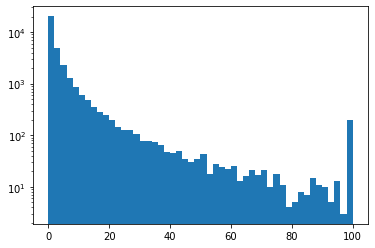

In [0]:
import matplotlib.pyplot as plt
plt.yscale('log')
_ = plt.hist([len(rcosims) for sense, rcosims in blc.items()], bins=50)

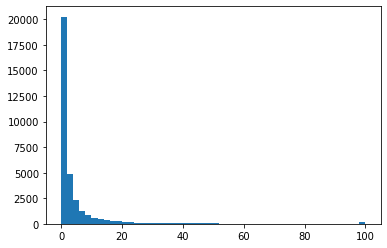

In [0]:
_ = plt.hist([len(rcosims) for sense, rcosims in blc.items()], bins=50)

Most of the senses. 20K out of 33K, only occur once or twice in semcor. Then there's a tail of senses with increasing occurrences. Only about 500 senses occur 100 times or more.


### **What do frequent sense rcosim plots look like**

In [0]:
senses_byfreq = [kv[0] for kv in sorted(blc.items(), key=lambda kv: len(kv[1]))]

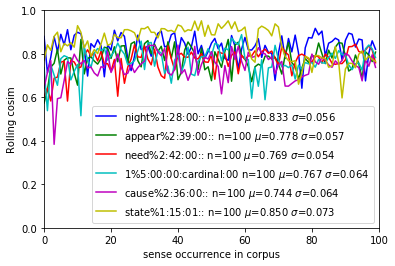

In [0]:
_ = plot_senses(blc, senses_byfreq[-6:]) # most frequent senses

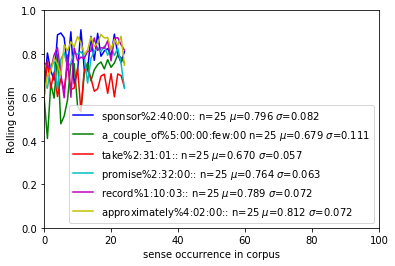

In [0]:
# some less frequent senses, but still visible
_ = plot_senses(blc, senses_byfreq[32000:32006]) 

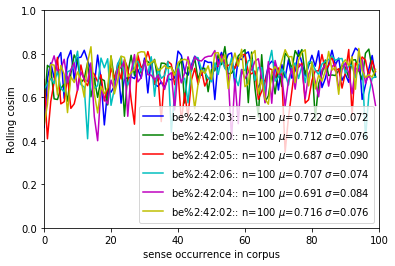

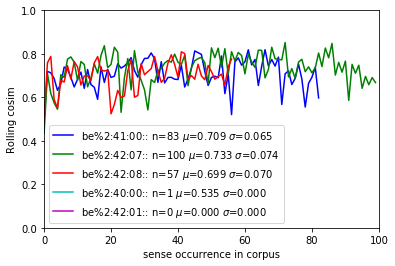

In [0]:
# senses for lemma 'be'
plot_senses(blc, lemma="be")

It seems that even the embeddings for the most frequent lemmas are quite unstable, pattern that is sharpened even more when the frequency of appearance is lower.

##Embedding projector

In order to visualize how the embeddings for a specific lemma are distributed, we will use the embedding projector of Tensorflow (https://projector.tensorflow.org/)

![alt text](https://github.com/hybridnlp/tutorial/raw/master/images/long_projection_1.png)

We are going to visualize the embeddings of the lemma "long". To do so, download the next files in your computer: [long.tsv](https://github.com/hybridnlp/tutorial/raw/master/datasamples/long.tsv) and [long.meta.tsv](https://github.com/hybridnlp/tutorial/raw/master/datasamples/long.meta.tsv). Once you have done it, click the load button in the upper-left corner of Tensorflow Projector and then choose your files (long.tsv for vectors and long.meta.tsv for metadata)


![alt text](https://github.com/hybridnlp/tutorial/raw/master/images/long_projection_2.png)

Now we can see the embeddings of the lemma long projected in three dimensions. To visualize how the clustering algorithms classify these embeddings, select tthe sense labels in the upper-left menu.

![alt text](https://github.com/hybridnlp/tutorial/raw/master/images/long_projection_3.png)
![alt text](https://github.com/hybridnlp/tutorial/raw/master/images/long_projection_4.png)

You can select different algorithms to cluster the data and see the results

![alt text](https://github.com/hybridnlp/tutorial/raw/master/images/long_projection_5.png)